# 通道策略
*用Python量化你的技术分析*

## 目录
- 通道是什么？
- 不同通道是怎么计算的？
- 通道如何用图表显示？
- 如何用通道构建策略？

## 通道是什么？
通道突破是技术分析中一个判断趋势的重要方法，其观念在于市场价格穿透了之前的价格压力或支撑，继而形成一股新的趋势，而交易策略的目标即是在突破发生时能够确认并建立仓位以获取趋势的利润。

## 不同通道是怎么计算的？
---
### 1. 均线百分比通道

$Upper = MA*1.03$

$lower = MA*0.97$

---

### 2. 布林带通道
$upper = MA+2\sigma$

$lower = MA-2\sigma$

---

### 3. 平均波幅通道
$upper = MA + ATR$

$lower = MA - ATR$

---

### 4. 高低价通道
$upper = Max(High,20)$

$lower = Min(low,20)$

## 通道如何用图表显示？

In [19]:
import pandas as pd
import warnings
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
# data = pd.Panel({s: pd.read_excel('threesymbol.xlsx', sheetname=s, index_col='datetime') 
#                    for s in ['BTCUSDT.binance', 'EOSUSDT.binance', 'ETHUSDT.binance']})
data = pd.read_excel('threesymbol.xlsx', sheetname='BTCUSDT.binance', index_col='datetime')

In [20]:
from talib import abstract

upperBand , middleBand, lowerBand = ta.BBANDS(data.close.values)

In [21]:
print(upperBand[-5:], '', middleBand[-5:],'', lowerBand[-5:])

[ 4696.16084516  4663.55942867  4617.17221956  4559.77036968  4548.22141639]  [ 4558.388  4531.308  4515.588  4499.528  4508.606]  [ 4420.61515484  4399.05657133  4414.00378044  4439.28563032  4468.99058361]


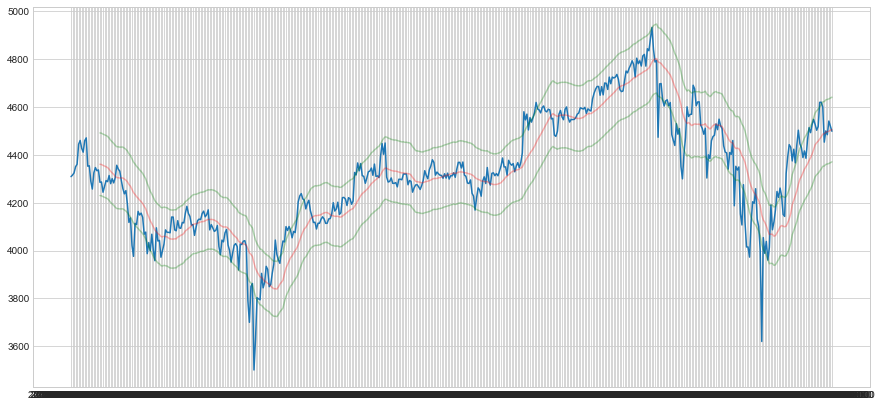

In [22]:
#均线百分比通道
data['close'] = data.close
middleband = ta.abstract.MA(data, timeperiod=20)
upperband = middleband*1.03
lowerband = middleband*0.97
data_B = pd.concat([middleband, upperband , lowerband], axis=1)
data_B.columns = ['middleband','upperband','lowerband']

plt.figure(figsize=(15,7))
plt.plot(data['close'])
plt.plot(data_B['middleband'], 'r', alpha=0.3)
plt.plot(data_B['upperband'], 'g', alpha=0.3)
plt.plot(data_B['lowerband'], 'g', alpha=0.3)
plt.show()

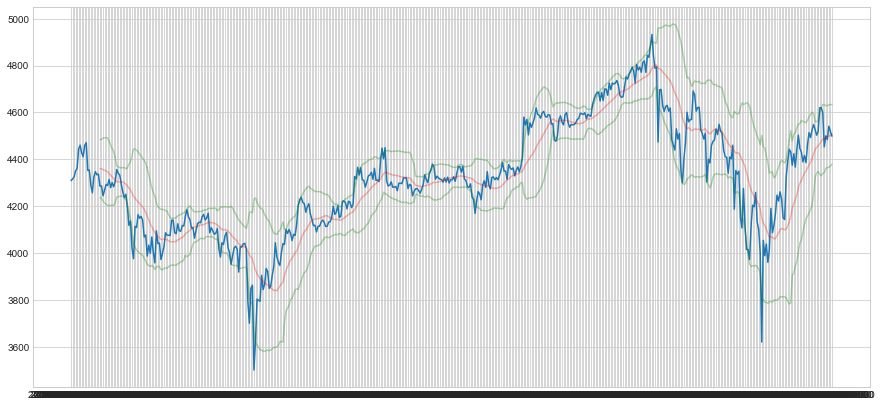

In [23]:
#布林带
data_B= ta.abstract.BBANDS(data, timeperiod=20)

plt.figure(figsize=(15,7))
plt.plot(data['close'])
plt.plot(data_B['middleband'], 'r', alpha=0.3)
plt.plot(data_B['upperband'], 'g', alpha=0.3)
plt.plot(data_B['lowerband'], 'g', alpha=0.3)
plt.show()

In [25]:
data['high']=data.high
data['low']=data.low

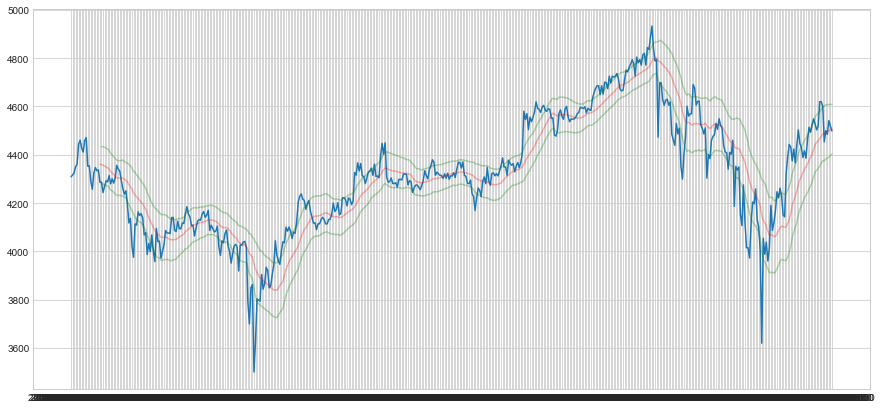

In [27]:
#平均波幅率通道线
atr = ta.abstract.ATR(data, 20)
middleband = ta.abstract.MA(data, 20)
upperband = middleband + atr
lowerband = middleband - atr
data_B = pd.concat([middleband, upperband, lowerband], axis=1)
data_B.columns = ['middleband', 'upperband', 'lowerband']

plt.figure(figsize=(15,7))
plt.plot(data['close'])
plt.plot(data_B['middleband'], 'r', alpha=0.3)
plt.plot(data_B['upperband'], 'g', alpha=0.3)
plt.plot(data_B['lowerband'], 'g', alpha=0.3)
plt.show()

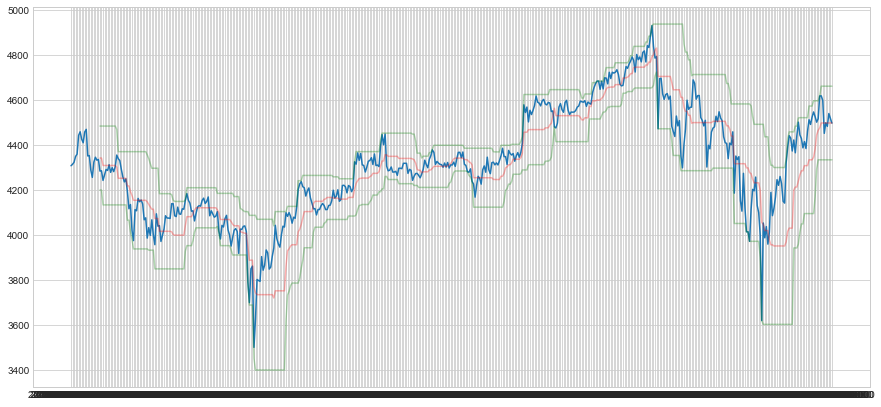

In [28]:
#高低价通道
upperband = ta.abstract.MAX(data, 20, price='high')
lowerband = ta.abstract.MIN(data, 20, price='low')
middleband = (upperband+lowerband)/2
data_B = pd.concat([middleband, upperband, lowerband], axis=1)
data_B.columns = ['middleband', 'upperband', 'lowerband']

plt.figure(figsize=(15,7))
plt.plot(data['close'])
plt.plot(data_B['middleband'], 'r', alpha=0.3)
plt.plot(data_B['upperband'], 'g', alpha=0.3)
plt.plot(data_B['lowerband'], 'g', alpha=0.3)
plt.show()

## 如何用通道构建策略？
### 1. Bollinger Band

Buy： 价格突破UpperBand 和 Sigma<0.005

Sell： b%>0.05

### 2. ATR Band

Buy ： 价格突破upperBand

Sell: 价格跌穿lowerband

In [ ]:
# Bollinger Band

    # 策略参数
    bBandPeriod = 60
    lots = 1
    stopRatio = 0.08  # 止损比例
    # 策略变量
    transactionPrice = {}
    up = {};up1={};up2={}
    mid= {}
    down= {}
    close1={};close2={}  
    
    # 设置变量
    self.setArrayManagerSize(self.bBandPeriod * 4)
    self.transactionPrice = {s: 0 for s in self.symbolList}
    self.up1={s: 0 for s in self.symbolList}
    self.up2={s: 0 for s in self.symbolList}
    self.close1={s: 0 for s in self.symbolList}
    self.close2={s: 0 for s in self.symbolList}

    # ----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        self.onBarExecute(bar)
        self.onBarRiskControl(bar)

    def onBarRiskControl(self, bar):
        symbol = bar.vtSymbol
        self.writeCtaLog(u'Bar%s'%(bar.__dict__))
        
        # 持有多头仓位
        if self.posDict[symbol + "_LONG"] > 0:
            if (bar.close < self.transactionPrice[symbol] * (1 - self.stopRatio)) or \
                    (bar.close > self.transactionPrice[symbol] * (1 + 2 * self.stopRatio)) :
                self.sell(symbol, bar.close * 0.98, self.posDict[symbol + "_LONG"])

        # 持有空头仓位
        elif self.posDict[symbol + "_SHORT"] > 0:
            if (bar.close > self.transactionPrice[symbol] * (1 + self.stopRatio)) or \
                    (bar.close < self.transactionPrice[symbol] * (1 - 2 * self.stopRatio)) :
                self.cover(symbol, bar.close * 1.02, self.posDict[symbol + "_SHORT"])

        self.putEvent()  # 每分钟更新一次UI界面

    def onBarExecute(self, bar):
        symbol = bar.vtSymbol
        am = self.getArrayManager(symbol, "1m")

        if not am.inited:
            return
        self.close1[symbol]=am.close[-1]
        self.close2[symbol]=am.close[-2]        


        sigma = (self.up1[symbol] -  self.close1[symbol]) / (2 *  self.close1[symbol])
        upsignal = self.close2[symbol] <= self.up2[symbol] and self.close1[symbol] >= self.up1[symbol]

        
        
        if upsignal and sigma < 0.005:
            if self.posDict[symbol + "_SHORT"] > 0:
                self.cover(symbol, bar.close * 1.02, self.posDict[symbol + "_SHORT"])
            elif self.posDict[symbol + "_LONG"] == 0:
                self.buy(symbol, bar.close * 1.02, self.lots)
        if sigma>0.05:
            if self.posDict[symbol + "_LONG"] > 0:
                self.sell(symbol, bar.close * 0.98, self.posDict[symbol + "_LONG"])
            elif self.posDict[symbol + "_SHORT"] == 0:
                self.short(symbol, bar.close * 0.98, self.lots)
                
        self.putEvent()  # 每分钟更新一次UI界面
    
    
    #信号计算
        self.up, self.mid, self.low = ta.BBANDS(am15.close, self.bBandPeriod, matype=0)  # parameter1
        self.up1[symbol]=self.up[-1]
        self.up2[symbol]=self.up[-2]
        
        
        # ----------------------------------------------------------------------
    def onTrade(self, trade):
        symbol = trade.vtSymbol
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onTrade
        self.transactionPrice[symbol] = trade.price

In [ ]:
#ATR_Band

    # 策略参数

    ABandPeriod = 60
    lots = 1
    stopRatio = 0.08  # 止损比例

    # 策略变量
    signal = {}  # 
    transactionPrice = {}
    #设置变量
        self.setArrayManagerSize(self.ABandPeriod * 4)
        self.transactionPrice = {s: 0 for s in self.symbolList}
        self.signal={s: 0 for s in self.symbolList}
        
        # 持有多头仓位
        if self.posDict[symbol + "_LONG"] > 0:
            if (bar.close < self.transactionPrice[symbol] * (1 - self.stopRatio)) or \
                    (bar.close > self.transactionPrice[symbol] * (1 + 2 * self.stopRatio)):
                self.sell(symbol, bar.close * 0.98, self.posDict[symbol + "_LONG"])

        # 持有空头仓位
        elif self.posDict[symbol + "_SHORT"] > 0:
            if (bar.close > self.transactionPrice[symbol] * (1 + self.stopRatio)) or \
                    (bar.close < self.transactionPrice[symbol] * (1 - 2 * self.stopRatio)):
                self.cover(symbol, bar.close * 1.02, self.posDict[symbol + "_SHORT"])

        #计算信号        
        MA = ta.SMA(am15.close, self.ABandPeriod)
        atr = ta.ATR(am15.high, am15.low, am15.close, timeperiod=self.ABandPeriod)
        upperband = MA[-1] + atr[-1]
        lowerband = MA[-1] - atr[-1]
        if bar.close > upperband:
            self.signal[symbol]=1
        elif bar.close < lowerband:
            self.signal[symbol]=-1
        #信号条件进出场
        if self.signal[symbol]==1:
            if self.posDict[symbol + "_SHORT"] > 0:
                self.cover(symbol, bar.close * 1.02, self.posDict[symbol + "_SHORT"])
            elif self.posDict[symbol + "_LONG"] == 0:
                self.buy(symbol, bar.close * 1.02, self.lots)
        if self.signal[symbol]==-1:
            if self.posDict[symbol + "_LONG"] > 0:
                self.sell(symbol, bar.close * 0.98, self.posDict[symbol + "_LONG"])
            elif self.posDict[symbol + "_SHORT"] == 0:
                self.short(symbol, bar.close * 0.98, self.lots)
                
    
    
    # ----------------------------------------------------------------------
    def onTrade(self, trade):
        symbol = trade.vtSymbol
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onTrade
        self.transactionPrice[symbol] = trade.price

# 作业：
写一个高低价通道突破策略